In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Package and dependency setup

In [4]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [1]:
!pip install imgaug==0.2.5

%cd /content
!touch requirements.txt
!echo -e "nipype \nnibabel \nmatplotlib \nscikit-fuzzy \nscikit-learn \nnilearn" > requirements.txt
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 562 kB 14.2 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-py3-none-any.whl size=561438 sha256=3c72422a816093e9e0702bcca8010d7d6a8c6d9428d85a7ac171bb58df95bdcd
  Stored in directory: /root/.cache/pip/wheels/60/dd/38/d1dc2cad2b6a66dc0249261004990bccb0f27985c74ba26e49
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 14.6 MB/s 
     |████████████████████████████████| 993 kB 58.7 MB/s 
     |████████████████████████████████| 9.6 MB 59.0 MB/s 
     |████████████████████████████████| 482 kB 67.6 MB/s 
     |████████████████████████████████| 421 kB 65.6 MB/s 
     |███

In [2]:
%matplotlib inline

import nibabel as nib
import matplotlib.pyplot as plt

Getting dataset

In [5]:
os.makedirs('/content/dataset')

In [6]:
from os import listdir
from os.path import isfile, join
import shutil


def _copyfileobj_patched(fsrc, fdst, length=16*1024*1024):
    """Patches shutil method to hugely improve copy speed"""
    while 1:
        buf = fsrc.read(length)
        if not buf:
            break
        fdst.write(buf)
shutil.copyfileobj = _copyfileobj_patched

In [9]:
''''Copying AD files'''

source_dir = r"/content/gdrive/MyDrive/Projects/ADNI-MRI/Data/Brain/AD"
destination_dir = r"/content/dataset/AD"
shutil.copytree(source_dir, destination_dir)

'/content/dataset/AD'

In [10]:
''''Copying CN files'''

source_dir = r"/content/gdrive/MyDrive/Projects/ADNI-MRI/Data/Brain/CN"
destination_dir = r"/content/dataset/CN"
shutil.copytree(source_dir, destination_dir)

'/content/dataset/CN'

In [11]:
%cd /content/dataset/AD
!ls | wc -l
%cd /content/dataset/NC
!ls | wc -l

/content/dataset/AD
75
[Errno 2] No such file or directory: '/content/dataset/NC'
/content/dataset/AD
75


Data loading and preprocessing

In [12]:
from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def intensity_range_transform(img, start_val=0, end_val=255):
  min = np.amin(img)
  timg = img.copy()

  timg = timg - min
  max = np.amax(timg)

  multiplier = ((end_val - start_val) / max)
  timg = (timg * multiplier) + start_val

  return timg.astype(int)


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    # volume[volume < min] = min
    # volume[volume > max] = max

    vol_min = np.amin(volume)
    volume = volume - vol_min
    multiplier = ((max - min)/max)
    volume = (volume * multiplier) + min

    # volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [13]:
%cd /content

/content


In [14]:
ad_scan_paths = [
    os.path.join(os.getcwd(), "dataset/AD", f)
    for f in os.listdir("/content/dataset/AD")
]

cn_scan_paths = [
    os.path.join(os.getcwd(), "dataset/CN", x)
    for x in os.listdir("/content/dataset/CN")
]

print("MRI scans with Alzheimers' disease: " + str(len(ad_scan_paths)))
print("MRI scans with Cognitive normality: " + str(len(cn_scan_paths)))


MRI scans with Alzheimers' disease: 75
MRI scans with Cognitive normality: 75


Build train and validation dataset

In [15]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
ad_scans = np.array([process_scan(path) for path in ad_scan_paths])
cn_scans = np.array([process_scan(path) for path in cn_scan_paths])

# For the MRI scans having presence of Alzheimers' disease
# assign 1, and for the cognitive normal ones assign 0.
ad_labels = np.array([1 for _ in range(len(ad_scans))])
cn_labels = np.array([0 for _ in range(len(cn_scans))])

train_percentage = 70
ad_train_amount = int(len(ad_scans) * train_percentage / 100)
cn_train_amount = int(len(cn_scans) * train_percentage / 100)

# Split data in the ratio 70-30 for training and validation
x_train = np.concatenate((ad_scans[:ad_train_amount], cn_scans[:cn_train_amount]), axis=0)
y_train = np.concatenate((ad_labels[:ad_train_amount], cn_labels[:cn_train_amount]), axis=0)
x_val = np.concatenate((ad_scans[ad_train_amount:], cn_scans[cn_train_amount:]), axis=0)
y_val = np.concatenate((ad_labels[ad_train_amount:], cn_labels[cn_train_amount:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 104 and 46.


In [16]:
x_train.shape

(104, 128, 128, 64)

Data augmentation

In [17]:
import random


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    # volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [18]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment them on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)


Visualize and augmented MRI scan

Dimension of the MRI scan is: (128, 128, 64, 1)


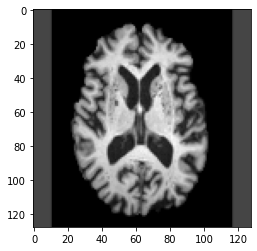

In [19]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap='gray')

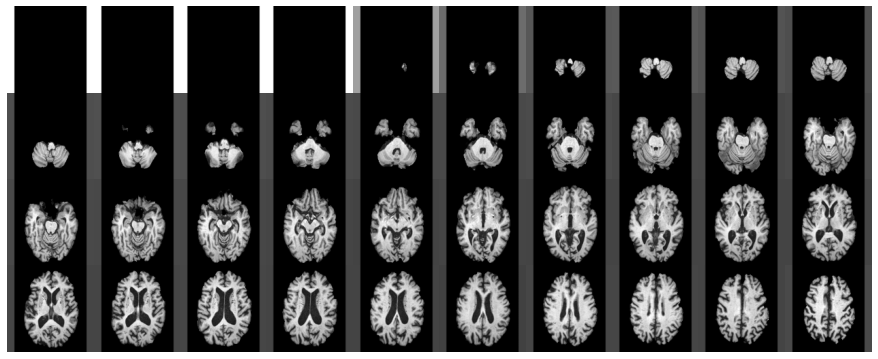

In [20]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 MRI slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])


Define a 3D convolution neural network

In [32]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_8 (Conv3D)           (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 63, 63, 31, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 63, 63, 31, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_9 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

Train model

In [33]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
52/52 - 11s - loss: 0.7474 - acc: 0.4327 - val_loss: 0.6983 - val_acc: 0.4783 - 11s/epoch - 207ms/step
Epoch 2/100
52/52 - 9s - loss: 0.7184 - acc: 0.5288 - val_loss: 1.2870 - val_acc: 0.4565 - 9s/epoch - 182ms/step
Epoch 3/100
52/52 - 10s - loss: 0.6863 - acc: 0.5962 - val_loss: 0.7735 - val_acc: 0.5000 - 10s/epoch - 184ms/step
Epoch 4/100
52/52 - 10s - loss: 0.6754 - acc: 0.5577 - val_loss: 0.7830 - val_acc: 0.5217 - 10s/epoch - 184ms/step
Epoch 5/100
52/52 - 9s - loss: 0.6617 - acc: 0.6827 - val_loss: 1.3884 - val_acc: 0.5000 - 9s/epoch - 182ms/step
Epoch 6/100
52/52 - 9s - loss: 0.7205 - acc: 0.5192 - val_loss: 0.7264 - val_acc: 0.5000 - 9s/epoch - 181ms/step
Epoch 7/100
52/52 - 10s - loss: 0.6887 - acc: 0.5577 - val_loss: 0.6661 - val_acc: 0.5652 - 10s/epoch - 184ms/step
Epoch 8/100
52/52 - 10s - loss: 0.6891 - acc: 0.5481 - val_loss: 0.8729 - val_acc: 0.5870 - 10s/epoch - 190ms/step
Epoch 9/100
52/52 - 9s - loss: 0.6693 - acc: 0.5962 - val_loss: 0.7214 - val_acc: 0.45

Visualizing model performance

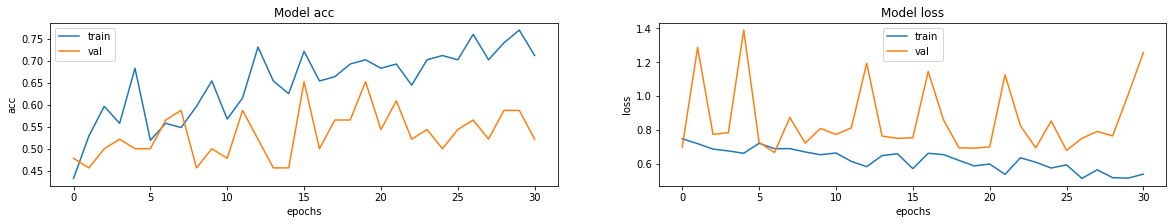

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [24]:
# Load best weights.
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["is cognitive normal", "has Alzheimer's disease"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that MRI scan %s"
        % ((100 * score), name)
    )

This model is 18.34 percent confident that MRI scan is cognitive normal
This model is 81.66 percent confident that MRI scan has Alzheimer's disease


Trying ResNet-18

In [35]:
!pip install git+https://github.com/JihongJu/keras-resnet3d.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JihongJu/keras-resnet3d.git to /tmp/pip-req-build-86c9e8q3
  Running command git clone -q https://github.com/JihongJu/keras-resnet3d.git /tmp/pip-req-build-86c9e8q3
  Running command git submodule update --init --recursive -q
  Created wheel for keras-resnet3d: filename=keras_resnet3d-0.0.1-py3-none-any.whl size=4765 sha256=b526649ba135e67007272edcf147ecf79c02306f3e6d8e54ec4dcca7c7471aad
  Stored in directory: /tmp/pip-ephem-wheel-cache-4muq6r1k/wheels/7e/d8/d8/79a8e9fdfacb40c998db593c423f1dd764cd65ceb66246d6f1
Successfully built keras-resnet3d


In [37]:
from resnet3d import Resnet3DBuilder
model = Resnet3DBuilder.build_resnet_18((128, 128, 64, 1), 1)

In [38]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
52/52 - 13s - loss: 1.6550 - acc: 0.5865 - val_loss: 1.9257 - val_acc: 0.5000 - 13s/epoch - 257ms/step
Epoch 2/100
52/52 - 9s - loss: 1.5370 - acc: 0.6731 - val_loss: 1.6395 - val_acc: 0.5435 - 9s/epoch - 171ms/step
Epoch 3/100
52/52 - 8s - loss: 1.5576 - acc: 0.5865 - val_loss: 2.3864 - val_acc: 0.5000 - 8s/epoch - 149ms/step
Epoch 4/100
52/52 - 8s - loss: 1.4988 - acc: 0.6923 - val_loss: 1.6623 - val_acc: 0.5000 - 8s/epoch - 153ms/step
Epoch 5/100
52/52 - 8s - loss: 1.3535 - acc: 0.7981 - val_loss: 1.6783 - val_acc: 0.5217 - 8s/epoch - 148ms/step
Epoch 6/100
52/52 - 9s - loss: 1.2730 - acc: 0.8558 - val_loss: 1.5435 - val_acc: 0.5435 - 9s/epoch - 172ms/step
Epoch 7/100
52/52 - 8s - loss: 1.2827 - acc: 0.8173 - val_loss: 1.5976 - val_acc: 0.5652 - 8s/epoch - 146ms/step
Epoch 8/100
52/52 - 8s - loss: 1.0870 - acc: 0.9519 - val_loss: 1.7040 - val_acc: 0.6087 - 8s/epoch - 147ms/step
Epoch 9/100
52/52 - 9s - loss: 1.0501 - acc: 0.9423 - val_loss: 1.5394 - val_acc: 0.5870 - 9s/

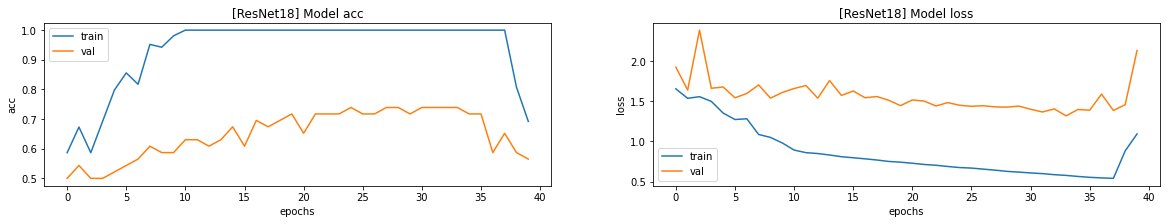

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("[ResNet18] Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Trying ResNet-50

In [48]:
model = Resnet3DBuilder.build_resnet_50((128, 128, 64, 1), 1)

In [49]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

In [50]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)


model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
52/52 - 20s - loss: 5.9970 - acc: 0.5962 - val_loss: 6.0271 - val_acc: 0.4565 - 20s/epoch - 392ms/step
Epoch 2/100
52/52 - 11s - loss: 5.8421 - acc: 0.6250 - val_loss: 6.0581 - val_acc: 0.5000 - 11s/epoch - 202ms/step
Epoch 3/100
52/52 - 10s - loss: 5.6046 - acc: 0.7692 - val_loss: 6.1928 - val_acc: 0.5000 - 10s/epoch - 201ms/step
Epoch 4/100
52/52 - 13s - loss: 5.4646 - acc: 0.7788 - val_loss: 5.7834 - val_acc: 0.4565 - 13s/epoch - 241ms/step
Epoch 5/100
52/52 - 10s - loss: 5.3462 - acc: 0.8077 - val_loss: 5.9865 - val_acc: 0.5435 - 10s/epoch - 201ms/step
Epoch 6/100
52/52 - 13s - loss: 5.0863 - acc: 0.9231 - val_loss: 5.4114 - val_acc: 0.6957 - 13s/epoch - 243ms/step
Epoch 7/100
52/52 - 10s - loss: 5.0643 - acc: 0.8846 - val_loss: 5.5629 - val_acc: 0.5435 - 10s/epoch - 201ms/step
Epoch 8/100
52/52 - 13s - loss: 5.0203 - acc: 0.8173 - val_loss: 5.2701 - val_acc: 0.7174 - 13s/epoch - 241ms/step
Epoch 9/100
52/52 - 13s - loss: 4.8553 - acc: 0.9327 - val_loss: 5.1618 - val_ac

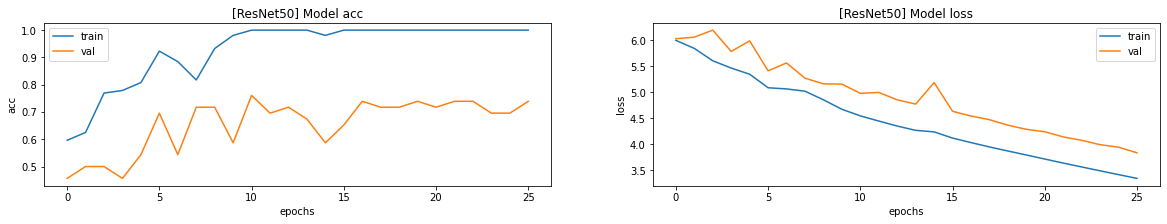

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("[ResNet50] Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

Trying ResNet-152

In [53]:
model = Resnet3DBuilder.build_resnet_152((128, 128, 64, 1), 1)

In [54]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

In [55]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)


model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
52/52 - 51s - loss: 15.7941 - acc: 0.5962 - val_loss: 22.9735 - val_acc: 0.5000 - 51s/epoch - 979ms/step
Epoch 2/100
52/52 - 27s - loss: 15.4549 - acc: 0.6923 - val_loss: 17.4389 - val_acc: 0.5000 - 27s/epoch - 515ms/step
Epoch 3/100
52/52 - 26s - loss: 15.2321 - acc: 0.6923 - val_loss: 15.2049 - val_acc: 0.5435 - 26s/epoch - 508ms/step
Epoch 4/100
52/52 - 27s - loss: 14.8975 - acc: 0.7500 - val_loss: 15.1013 - val_acc: 0.5217 - 27s/epoch - 513ms/step
Epoch 5/100
52/52 - 27s - loss: 14.6324 - acc: 0.7788 - val_loss: 14.8362 - val_acc: 0.5217 - 27s/epoch - 513ms/step
Epoch 6/100
52/52 - 28s - loss: 14.2915 - acc: 0.8558 - val_loss: 14.8239 - val_acc: 0.5870 - 28s/epoch - 529ms/step
Epoch 7/100
52/52 - 20s - loss: 13.9023 - acc: 0.9135 - val_loss: 14.8409 - val_acc: 0.5652 - 20s/epoch - 379ms/step
Epoch 8/100
52/52 - 27s - loss: 13.6781 - acc: 0.9135 - val_loss: 14.3452 - val_acc: 0.5000 - 27s/epoch - 512ms/step
Epoch 9/100
52/52 - 26s - loss: 13.3575 - acc: 0.9423 - val_loss

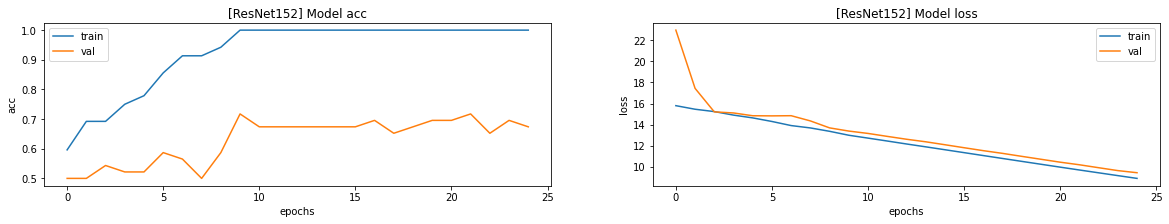

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("[ResNet152] Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])